# Project Optimization for Machine Learning 

Maxence Lasbordes | M2 MASH

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

## Question 1

For this project we will use the a9a dataset. This dataset is a binary classification problem with sparse features. The goal is to predict whether an individual makes over 50K a year based on the features provided. The dataset is available at the following URL: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

In [3]:
with open('a9a.txt', 'r') as file:
    lines = file.readlines()

labels = []
features = []

for line in lines:
    parts = line.strip().split()
    
    labels.append(int(parts[0]))
    
    feature_dict = {}
    for feat in parts[1:]:
        index, value = feat.split(':')
        feature_dict[int(index)] = float(value)
    
    features.append(feature_dict)

The dataset contains 32561 samples and 123 features. The features are very sparse. We are only focusing on the training set which contains 32561 samples.

In [8]:
print('Number of samples:', len(labels))
print('Number of features:', len(features[0]))
print(labels[:5])
print(features[:5])

Number of samples: 32561
Number of features: 14
[-1, -1, -1, -1, -1]
[{3: 1.0, 11: 1.0, 14: 1.0, 19: 1.0, 39: 1.0, 42: 1.0, 55: 1.0, 64: 1.0, 67: 1.0, 73: 1.0, 75: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {5: 1.0, 7: 1.0, 14: 1.0, 19: 1.0, 39: 1.0, 40: 1.0, 51: 1.0, 63: 1.0, 67: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 78: 1.0, 83: 1.0}, {3: 1.0, 6: 1.0, 17: 1.0, 22: 1.0, 36: 1.0, 41: 1.0, 53: 1.0, 64: 1.0, 67: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {5: 1.0, 6: 1.0, 17: 1.0, 21: 1.0, 35: 1.0, 40: 1.0, 53: 1.0, 63: 1.0, 71: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {2: 1.0, 6: 1.0, 18: 1.0, 19: 1.0, 39: 1.0, 40: 1.0, 52: 1.0, 61: 1.0, 71: 1.0, 72: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 95: 1.0}]


We can see that the dataset is in a sparse format. Only the non-zero features are specified.

In [4]:
max_index = max([max(feat.keys()) for feat in features if feat])
dense_features = np.zeros((len(features), max_index))

# The features are 1-indexed so we shift them to 0-indexed
for i, feat in enumerate(features):
    for index, value in feat.items():
        dense_features[i, index-1] = value
print(dense_features[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


We now have the full dense matrix, so we can generate the correlation matrix.

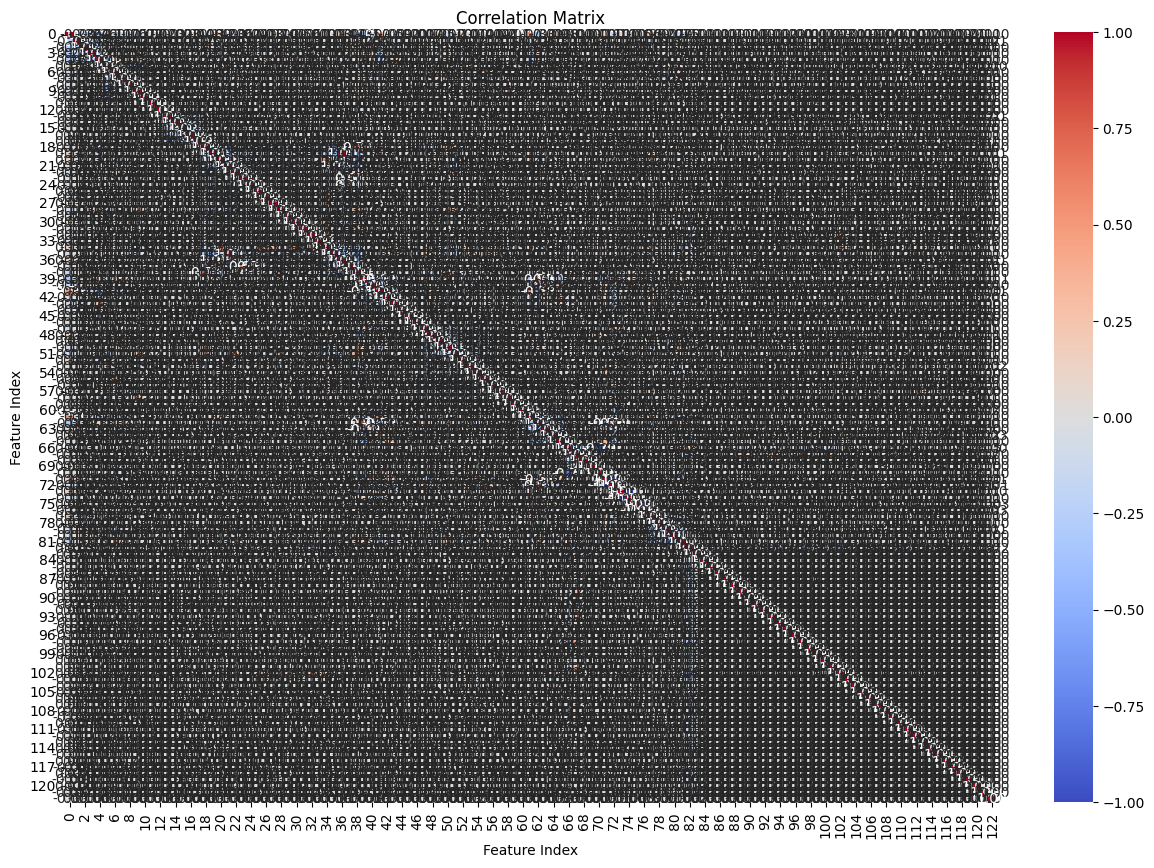

In [5]:
dataframe = pd.DataFrame(dense_features)
correlation_matrix = dataframe.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()


Because of the huge number of features (123), it is very hard to visualize correctly the correlation matrix.

## Qestion 2

We will build the f function and the gradient of the f function.

In [5]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def f_i(x, a_i, y_i):
    return (y_i - sigmoid(torch.dot(a_i, x))) ** 2

def grad_f_i_explicit(x, a_i, y_i):
    exp_term = torch.exp(torch.dot(a_i, x))
    numerator = 2 * exp_term * (exp_term * (y_i - 1) + y_i)
    denominator = (1 + exp_term) ** 3
    return - (numerator / denominator) * a_i

We will now compare the explicit computation of the gradient with the gradient from the automatic differentiation.

In [6]:
a_i = torch.tensor(dense_features[0], dtype=torch.float32)
y_i = torch.tensor(labels[0], dtype=torch.float32)
x = torch.randn(a_i.size(0), requires_grad=True)


f_value = f_i(x, a_i, y_i)
f_value.backward() # Compute the gradients
grad_f_i_autograd = x.grad # Get the gradients
grad_f_i_explicit = grad_f_i_explicit(x, a_i, y_i)

print("Autograd gradient:", grad_f_i_autograd)
print("Explicit gradient:", grad_f_i_explicit)

# We check if the gradients match with a small tollerance
if torch.allclose(grad_f_i_autograd, grad_f_i_explicit):
    print("\nValidation: Gradients match !!!")
else:
    print("\nValidation: Gradients do not match !!!")

Autograd gradient: tensor([0.0000, 0.0000, 0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0264, 0.0000, 0.0000, 0.0264, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0264, 0.0000, 0.0000, 0.0264, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0264, 0.0000, 0.0000, 0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0264, 0.0000, 0.0264, 0.0264, 0.0000, 0.0000, 0.0000, 0.0264, 0.0000,
        0.0000, 0.0264, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.000

As expected, the gradients are indeed matching !

## Question 3

Implementation of gradient descent for our problem. We reused a part of the code from the Lab 2.

In [7]:
def f(x, A, y):
    n = A.shape[0]
    return torch.mean(torch.stack([f_i(x, A[i], y[i]) for i in range(n)]))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Let's test the function with a small subset of 1000 data points to make it faster
A = torch.tensor(dense_features[:1000], dtype=torch.float32, device=device)
y = torch.tensor(labels[:1000], dtype=torch.float32, device=device)
x = torch.randn(A.size(1), requires_grad=True, device=device)

Step size 3, Iteration 0/100 : Loss : 2.664558172225952
Step size 3, Iteration 10/100 : Loss : 1.0090959072113037
Step size 3, Iteration 20/100 : Loss : 1.0035134553909302
Step size 3, Iteration 30/100 : Loss : 1.0018078088760376
Step size 3, Iteration 40/100 : Loss : 1.0009260177612305
Step size 3, Iteration 50/100 : Loss : 1.0003631114959717
Step size 3, Iteration 60/100 : Loss : 0.9999448657035828
Step size 3, Iteration 70/100 : Loss : 0.9995884299278259
Step size 3, Iteration 80/100 : Loss : 0.999247670173645
Step size 3, Iteration 90/100 : Loss : 0.9988929033279419
Step size 2.5, Iteration 0/100 : Loss : 2.1572928428649902
Step size 2.5, Iteration 10/100 : Loss : 1.004987359046936
Step size 2.5, Iteration 20/100 : Loss : 0.9997926950454712
Step size 2.5, Iteration 30/100 : Loss : 0.9979997277259827
Step size 2.5, Iteration 40/100 : Loss : 0.9966457486152649
Step size 2.5, Iteration 50/100 : Loss : 0.9950953125953674
Step size 2.5, Iteration 60/100 : Loss : 0.9930862188339233
Step 

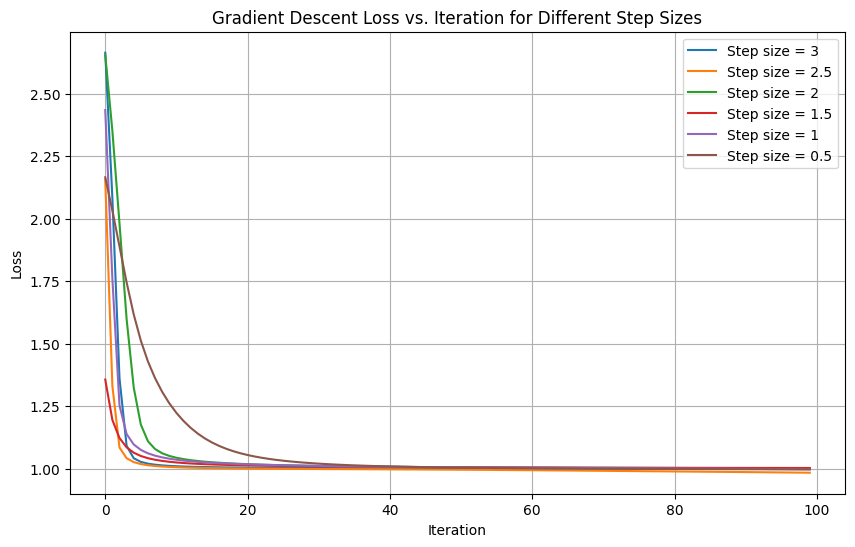

In [27]:
nb_iters = 100
step_sizes = [3, 2.5, 2, 1.5, 1, 0.5]

losses_dict = {stepsize: [] for stepsize in step_sizes}

for stepsize in step_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for i in range(nb_iters):
        loss = f(x, A, y)
        loss.backward()
        with torch.no_grad():
            x -= stepsize*x.grad
            x.grad.zero_()

        losses_dict[stepsize].append(loss.detach().item())
        
        if i % 10 == 0:
            print(f"Step size {stepsize}, Iteration {i}/{nb_iters} : Loss : {loss.item()}")

# Plot the losses for each step size
plt.figure(figsize=(10, 6))
for stepsize, losses in losses_dict.items():
    plt.plot(range(nb_iters ), losses, label=f"Step size = {stepsize}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Gradient Descent Loss vs. Iteration for Different Step Sizes")
plt.legend()
plt.grid()
plt.show()

- The expected gradient descent convergence rate for **non-convex functions** is $O\left(\frac{1}{\sqrt{k}}\right)$, where $k$ is the number of iterations. And we can observe this convergence rate empirically on the previous plot for the 0.5 step size.
- Since it is a non convexe optimization problem we don't have a defined best constant stepsize, but experimentally I found that a good constant stepsize seems to be around 2.5.

## Question 4

Implementation of the Batch Stochastic Gradient Descent with various constant step sizes.

Step size 3, Iteration 0/100 : Loss : 1.1546683731079102
Step size 3, Iteration 10/100 : Loss : 1.023925582885742
Step size 3, Iteration 20/100 : Loss : 1.0228278579711914
Step size 3, Iteration 30/100 : Loss : 1.0213252487182618
Step size 3, Iteration 40/100 : Loss : 1.0170421028137206
Step size 3, Iteration 50/100 : Loss : 0.988555347442627
Step size 3, Iteration 60/100 : Loss : 0.9664063682556152
Step size 3, Iteration 70/100 : Loss : 0.9595925788879395
Step size 3, Iteration 80/100 : Loss : 0.9609048500061035
Step size 3, Iteration 90/100 : Loss : 0.9527552986145019
Step size 2.5, Iteration 0/100 : Loss : 1.1847616500854492
Step size 2.5, Iteration 10/100 : Loss : 1.019697898864746
Step size 2.5, Iteration 20/100 : Loss : 1.0104311866760254
Step size 2.5, Iteration 30/100 : Loss : 0.9968279838562012
Step size 2.5, Iteration 40/100 : Loss : 0.9811260528564453
Step size 2.5, Iteration 50/100 : Loss : 0.9696905479431153
Step size 2.5, Iteration 60/100 : Loss : 0.9613385009765625
Step 

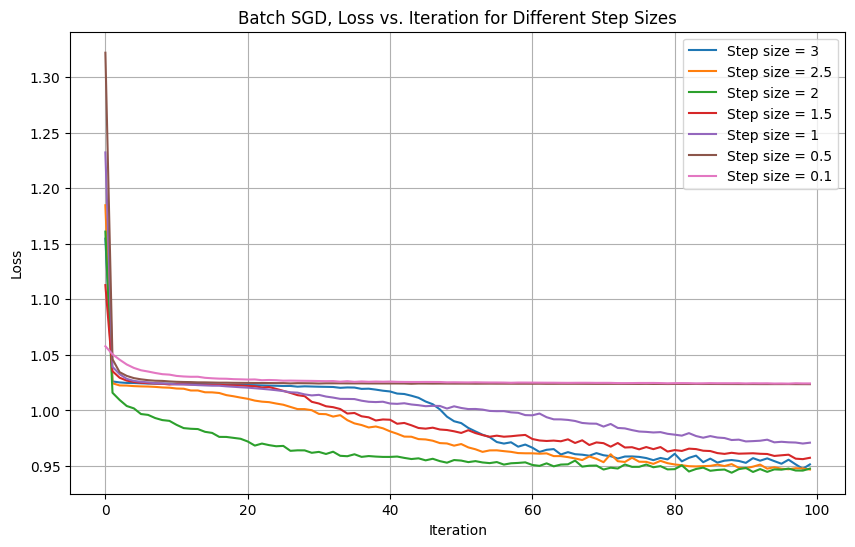

In [25]:
batch_size = 64
nb_iters = 100
step_sizes = [3, 2.5, 2, 1.5, 1, 0.5, 0.1]

losses_dict = {stepsize: [] for stepsize in step_sizes}

for stepsize in step_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for i in range(nb_iters):
        # Shuffle data
        indices = torch.randperm(A.size(0))
        A_shuffled = A[indices]
        y_shuffled = y[indices]
        
        total_loss = 0
        for b in range(0, A.size(0), batch_size):
            
            A_batch = A_shuffled[b:b+batch_size]
            y_batch = y_shuffled[b:b+batch_size]
            
            loss = f(x, A_batch, y_batch)
            total_loss += loss.item()
            loss.backward()
        
            with torch.no_grad():
                x -= stepsize * x.grad
                x.grad.zero_()
        
        # Average loss over all batches
        avg_loss = total_loss / (A.size(0) / batch_size)
        losses_dict[stepsize].append(avg_loss)
        
        if i % 10 == 0:
            print(f"Step size {stepsize}, Iteration {i}/{nb_iters} : Loss : {avg_loss}")
            
# Plot the losses for each step size
plt.figure(figsize=(10, 6))
for stepsize, losses in losses_dict.items():
    plt.plot(range(nb_iters ), losses, label=f"Step size = {stepsize}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Batch SGD, Loss vs. Iteration for Different Step Sizes")
plt.legend()
plt.grid()
plt.show()

- In theory, Batch SGD has faster convergence per epoch because we update each parameter multiple times. The results confirm this theory, as the loss evolution is more consistent and lower after 100 epochs for the best constant step sizes (around 2).
- The best constant step size seems to be around 2 and the best batch size for this step size is 16, as we can see in the next graph computed.

Batch size 16, Iteration 0/100 : Loss : 1.0235707645416259
Batch size 16, Iteration 10/100 : Loss : 1.0055623931884765
Batch size 16, Iteration 20/100 : Loss : 0.9675137491226197
Batch size 16, Iteration 30/100 : Loss : 0.9451260385513306
Batch size 16, Iteration 40/100 : Loss : 0.9405264234542847
Batch size 16, Iteration 50/100 : Loss : 0.931425666809082
Batch size 16, Iteration 60/100 : Loss : 0.9289030733108521
Batch size 16, Iteration 70/100 : Loss : 0.9272193994522094
Batch size 16, Iteration 80/100 : Loss : 0.9232718620300293
Batch size 16, Iteration 90/100 : Loss : 0.9219477376937866
Batch size 32, Iteration 0/100 : Loss : 1.1082077045440675
Batch size 32, Iteration 10/100 : Loss : 0.993027774810791
Batch size 32, Iteration 20/100 : Loss : 0.9672133560180665
Batch size 32, Iteration 30/100 : Loss : 0.9573148670196533
Batch size 32, Iteration 40/100 : Loss : 0.956892988204956
Batch size 32, Iteration 50/100 : Loss : 0.9545345840454101
Batch size 32, Iteration 60/100 : Loss : 0.95

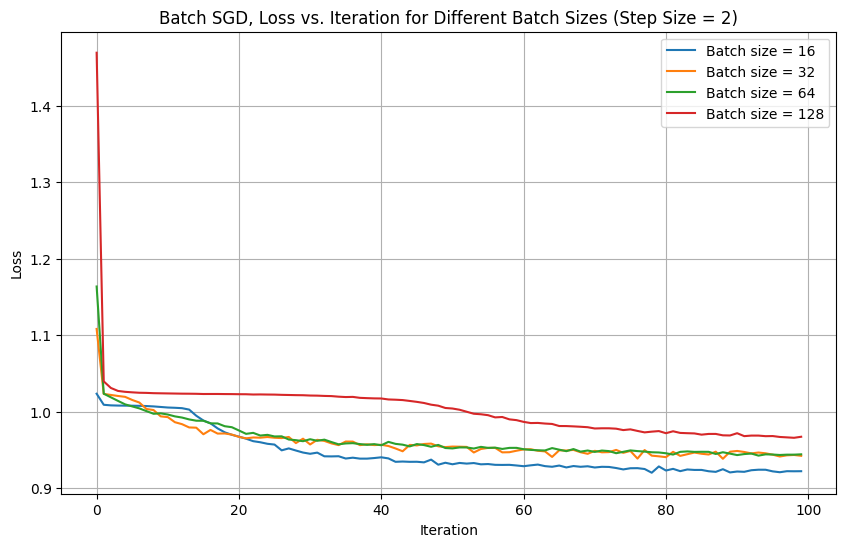

In [29]:
batch_sizes = [16, 32, 64, 128]  # Test these batch sizes
step_size = 2  # Since we found it was the best step size
nb_iters = 100  # Number of iterations

losses_dict = {batch_size: [] for batch_size in batch_sizes}

# Batch SGD with constant step size
for batch_size in batch_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for i in range(nb_iters):
        # Shuffle data
        indices = torch.randperm(A.size(0))
        A_shuffled = A[indices]
        y_shuffled = y[indices]
        
        total_loss = 0
        for b in range(0, A.size(0), batch_size):
            A_batch = A_shuffled[b:b+batch_size]
            y_batch = y_shuffled[b:b+batch_size]
            
            loss = f(x, A_batch, y_batch)
            total_loss += loss.item()
            
            loss.backward()

            with torch.no_grad():
                x -= step_size * x.grad
                x.grad.zero_()
        
        # Average loss over all batches
        avg_loss = total_loss / (A.size(0) / batch_size)
        losses_dict[batch_size].append(avg_loss)
        
        if i % 10 == 0:
            print(f"Batch size {batch_size}, Iteration {i}/{nb_iters} : Loss : {avg_loss}")

# Plot the losses for each batch size
plt.figure(figsize=(10, 6))
for batch_size, losses in losses_dict.items():
    plt.plot(range(nb_iters), losses, label=f"Batch size = {batch_size}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Batch SGD, Loss vs. Iteration for Different Batch Sizes (Step Size = {step_size})")
plt.legend()
plt.grid()
plt.show()

## Question 5

We will now implement Adagrad and compare it with the best result from Batch SGD with batch size of 16 and a learning rate of 2.

Adagrad, Iteration 0/100 : Loss : 1.0305967149734496
Adagrad, Iteration 10/100 : Loss : 1.008000033378601
Adagrad, Iteration 20/100 : Loss : 0.9556193971633911
Adagrad, Iteration 30/100 : Loss : 0.9250918388366699
Adagrad, Iteration 40/100 : Loss : 0.919551064491272
Adagrad, Iteration 50/100 : Loss : 0.9203454561233521
Adagrad, Iteration 60/100 : Loss : 0.920179780960083
Adagrad, Iteration 70/100 : Loss : 0.9187260503768921
Adagrad, Iteration 80/100 : Loss : 0.9186650571823121
Adagrad, Iteration 90/100 : Loss : 0.9184637098312378


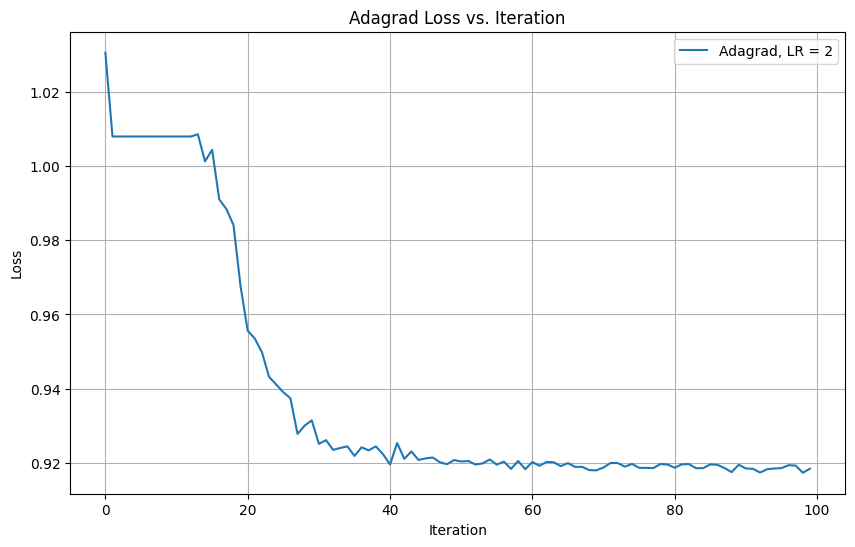

In [30]:
batch_size = 16
nb_iters = 100
lr = 2
epsilon = 1e-8

x = torch.randn(A.size(1), requires_grad=True, device=device)
G = torch.zeros_like(x, device=device)
adagrad_losses = []
for i in range(nb_iters):
    indices = torch.randperm(A.size(0))
    A_shuffled = A[indices]
    y_shuffled = y[indices]
    total_loss = 0
    for b in range(0, A.size(0), batch_size):
        A_batch = A_shuffled[b:b+batch_size]
        y_batch = y_shuffled[b:b+batch_size]
        loss = f(x, A_batch, y_batch)
        total_loss += loss.item()
        loss.backward()
        G.add_(x.grad.pow(2))
        with torch.no_grad():
            x -= lr / torch.sqrt(G + epsilon) * x.grad
            x.grad.zero_()
    avg_loss = total_loss / (A.size(0) / batch_size)
    adagrad_losses.append(avg_loss)
    if i % 10 == 0:
        print(f"Adagrad, Iteration {i}/{nb_iters} : Loss : {avg_loss}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(nb_iters), adagrad_losses, label=f"Adagrad, LR = {lr}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Adagrad Loss vs. Iteration")
plt.legend()
plt.grid()
plt.show()

- As expected, the results are slighly better with Adagrad compared to the Batch SGD for the same configuration.

## Question 6

We will now implement the proximal gradient approach with the regularized version of the problem. We take 100 iterations and a step size of 2.5 based on previous experiments.

Lambda 0.001, Iteration 0/100 : Total Loss : 1.2112164497375488
Lambda 0.001, Iteration 10/100 : Total Loss : 1.1055488586425781
Lambda 0.001, Iteration 20/100 : Total Loss : 1.0972968339920044
Lambda 0.001, Iteration 30/100 : Total Loss : 1.0927987098693848
Lambda 0.001, Iteration 40/100 : Total Loss : 1.0893619060516357
Lambda 0.001, Iteration 50/100 : Total Loss : 1.0863395929336548
Lambda 0.001, Iteration 60/100 : Total Loss : 1.0835148096084595
Lambda 0.001, Iteration 70/100 : Total Loss : 1.0808029174804688
Lambda 0.001, Iteration 80/100 : Total Loss : 1.0781748294830322
Lambda 0.001, Iteration 90/100 : Total Loss : 1.075649619102478
Lambda = 0.001: Sparsity = 17.07%
Lambda 0.01, Iteration 0/100 : Total Loss : 3.3568742275238037
Lambda 0.01, Iteration 10/100 : Total Loss : 1.8014874458312988
Lambda 0.01, Iteration 20/100 : Total Loss : 1.5916409492492676
Lambda 0.01, Iteration 30/100 : Total Loss : 1.427121877670288
Lambda 0.01, Iteration 40/100 : Total Loss : 1.3054752349853516


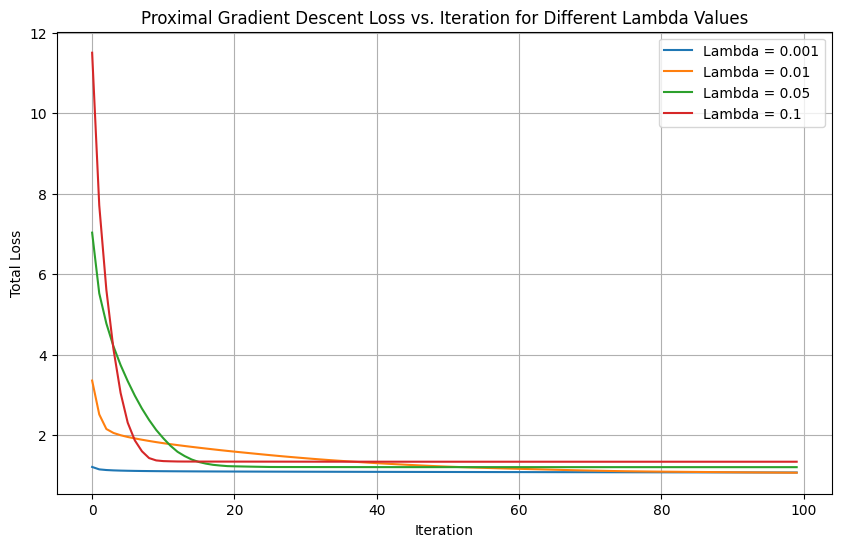

In [16]:
nb_iters = 100
step_size = 2.5
lambda_values = [0.001, 0.01, 0.05, 0.1]  # Test these lambda values

losses_dict = {lambdaa: [] for lambdaa in lambda_values}
sparsity_dict = {lambdaa: 0.0 for lambdaa in lambda_values}

for lambdaa in lambda_values:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    
    for i in range(nb_iters):
        loss = f(x, A, y)
        
        l1_term = lambdaa * torch.norm(x, p=1)
        total_loss = loss + l1_term
        
        loss.backward()

        with torch.no_grad():
            x_new = x - step_size * x.grad
            x_prox = torch.sign(x_new) * torch.clamp(torch.abs(x_new) - step_size * lambdaa, min=0.0)
            x.copy_(x_prox)
            x.grad.zero_()
        
        losses_dict[lambdaa].append(total_loss.item())
        
        if i % 10 == 0:
            print(f"Lambda {lambdaa}, Iteration {i}/{nb_iters} : Total Loss : {total_loss.item()}")

    sparsity = (x == 0).float().mean().item() * 100
    print(f"Lambda = {lambdaa}: Sparsity = {sparsity:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
for lambdaa, losses in losses_dict.items():
    plt.plot(range(nb_iters), losses, label=f"Lambda = {lambdaa}")

plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Proximal Gradient Descent Loss vs. Iteration for Different Lambda Values")
plt.legend()
plt.grid()
plt.show()

- Lambda = 0.1 seems to be a good value for the regularization parameter as it yields a 91.87% of sparsity for the solution vector and the loss is still low.

## Question 7

Let's now implement the BFGS method and compare it with the regular gradient descent on the first problem. We reuse the variables name from the decription of the BFGS technique. We will use a constant step size of 0.1 and 100 iterations.

In [32]:
max_iters = 100
alpha = 0.1 # constant step size

x = torch.randn(A.size(1), requires_grad=True, device=device)
H = torch.eye(x.size(0), device=x.device)
losses = []

for i in range(max_iters):
    loss = f(x, A, y)
    losses.append(loss.item())
    loss.backward()
    g = x.grad.clone()
    x.grad.zero_()
    
    x_new = (x - alpha * torch.mv(H, g)).detach().requires_grad_(True)
    f_new = f(x_new, A, y)
    f_new.backward()
    g_new = x_new.grad.clone()
    x_new.grad.zero_()
    
    s = x_new - x
    v = g_new - g
    if torch.dot(s, v) > 0:
        rho = 1 / torch.dot(s, v)
        I = torch.eye(H.size(0), device=H.device)
        H = (I - rho * torch.outer(v, s)).T @ H @ (I - rho * torch.outer(v, s)) + rho * torch.outer(s, s)

    if i % 10 == 0 or i == max_iters - 1:
        print(f"Iteration {i}/{max_iters} : Loss : {loss.item()}")

    x = x_new.detach().requires_grad_(True)

Iteration 0/100 : Loss : 2.005444049835205
Iteration 10/100 : Loss : 1.0567195415496826
Iteration 20/100 : Loss : 1.016727089881897
Iteration 30/100 : Loss : 1.0052545070648193
Iteration 40/100 : Loss : 1.0014371871948242
Iteration 50/100 : Loss : 1.0000938177108765
Iteration 60/100 : Loss : 0.999609112739563
Iteration 70/100 : Loss : 0.9994114637374878
Iteration 80/100 : Loss : 0.9992786049842834
Iteration 90/100 : Loss : 0.998986005783081
Iteration 99/100 : Loss : 0.9942636489868164


- We observe very similar results between BFGS and the regular gradient descent. The loss is very similar. One thing to note is that the BFGS method is more computationally expensive than the regular gradient descent and we have nan values for the loss with bigger step sizes.

## Question 8